<a href="https://colab.research.google.com/github/JanLeyva/DeepLearning/blob/main/Assignment3_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [2]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [4]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 229s 5s/step - loss: 2.9659 - accuracy: 0.0534 - val_loss: 2.9474 - val_accuracy: 0.0523
Epoch 2/50
18/18 [==============================] - 46s 3s/step - loss: 2.9456 - accuracy: 0.0570 - val_loss: 2.9450 - val_accuracy: 0.0544
Epoch 3/50
18/18 [==============================] - 45s 3s/step - loss: 2.9425 - accuracy: 0.0609 - val_loss: 2.9381 - val_accuracy: 0.0654
Epoch 4/50
18/18 [==============================] - 45s 3s/step - loss: 2.9372 - accuracy: 0.0699 - val_loss: 2.9334 - val_accuracy: 0.0679
Epoch 5/50
18/18 [==============================] - 46s 3s/step - loss: 2.9269 - accuracy: 0.0754 - val_loss: 2.9227 - val_accuracy: 0.0768
Epoch 6/50
18/18 [==============================] - 46s 3s/step - loss: 2.9160 - accuracy: 0.0821 - val_loss: 2.9111 - val_accuracy: 0.0843
Epoch 7/50
18/18 [==============================] - 46s 3s/step - loss: 2.9058 - accuracy: 0.0868 - val_loss: 2.9020 - val_accuracy: 0.0903
Epoch 8/50
18/18 [=

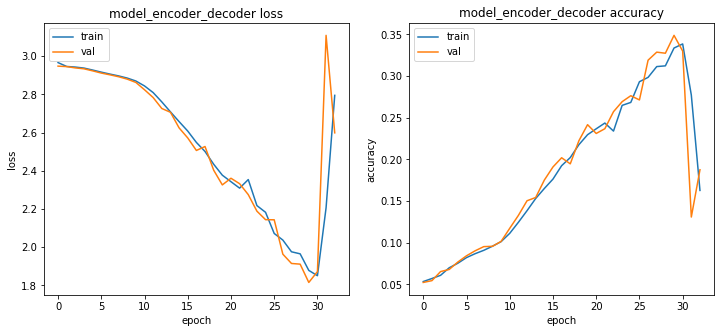

In [ ]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

Epoch 1/50
18/18 [==============================] - 230s 5s/step - loss: 2.9649 - accuracy: 0.0529 - val_loss: 2.9459 - val_accuracy: 0.0534
Epoch 2/50
18/18 [==============================] - 45s 3s/step - loss: 2.9456 - accuracy: 0.0537 - val_loss: 2.9447 - val_accuracy: 0.0536
Epoch 3/50
18/18 [==============================] - 47s 3s/step - loss: 2.9428 - accuracy: 0.0596 - val_loss: 2.9439 - val_accuracy: 0.0586
Epoch 4/50
18/18 [==============================] - 50s 3s/step - loss: 2.9390 - accuracy: 0.0656 - val_loss: 2.9346 - val_accuracy: 0.0733
Epoch 5/50
18/18 [==============================] - 48s 3s/step - loss: 2.9284 - accuracy: 0.0741 - val_loss: 2.9250 - val_accuracy: 0.0756
Epoch 6/50
18/18 [==============================] - 48s 3s/step - loss: 2.9168 - accuracy: 0.0819 - val_loss: 2.9102 - val_accuracy: 0.0839
Epoch 7/50
18/18 [==============================] - 46s 3s/step - loss: 2.9052 - accuracy: 0.0862 - val_loss: 2.9014 - val_accuracy: 0.0880
Epoch 8/50
18/18 [=

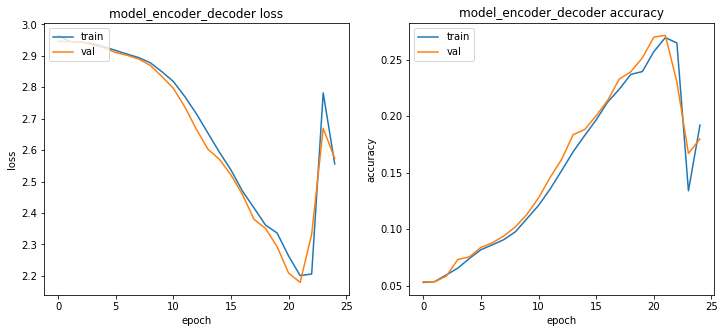

In [ ]:
# attention model
attentionBahdanau = BahdanauAttention(16, verbose = 0)
model_attentionBahdanau = build_attention_model(attention, batch_size, rnn_units)


#training
train_test(model_attentionBahdanau, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    self.verbose= verbose

  def call(self, query, values):
    if self.verbose:
      print('\n******* Bahdanau Attention STARTS******')
      print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
      print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    if self.verbose:
      print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    if self.verbose:
      print('score: (batch_size, max_length, 1) ',score.shape)
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    if self.verbose:
      print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    if self.verbose:
      print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    if self.verbose:
      print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
      print('\n******* Bahdanau Attention ENDS******')
    return context_vector, attention_weights

In [5]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    self.verbose= verbose

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values

    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [6]:
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

In [8]:
query_with_time_axis = tf.expand_dims(decoder_outputs, 1)
values_transposed = tf.transpose(encoder_outputs, perm=[0, 2, 1])

## Luong dot

In [9]:
score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

## Luong multiplicative

In [ ]:
W1 = tf.keras.layers.Dense(units) # we need a W as training paramater

score = tf.transpose( tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

In [13]:
(score)

<KerasTensor: shape=(None, 100, 1) dtype=float64 (created by layer 'tf.compat.v1.transpose_1')>

# Luong multiplicative

In [ ]:
class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Plot the Matrix Weigth

In [ ]:
def evaluate(seq_in):
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  print ('attention_plot shape: (n_timesteps_in, n_timesteps_in) {}'.format(attention_plot.shape))


  #sequence = [7, 9, 8, 5]
  sequence = one_hot_encode(seq_in,n_features)
  encoder_inputs=array(sequence).reshape(1,n_timesteps_in,n_features)
  
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  print ('Encoder input shape: (batch size, sequence length, n_features) {}'.format(encoder_inputs.shape))


  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

  print ('Encoder output shape: (batch size, sequence length, latentSpaceDimension) {}'.format(encoder_outputs.shape))
  print ('Encoder Hidden state shape: (batch size, latentSpaceDimension) {}'.format(state_h.shape))
  print ('Encoder Cell state shape: (batch size, latentSpaceDimension) {}'.format(state_c.shape))
  # initial context vector is the states of the encoder
  states = [state_h, state_c]
  
  # Set up the attention layer
  #attention= BahdanauAttention(latentSpaceDimension)


  # Set up the decoder layers
  #decoder_inputs = Input(shape=(1, (n_features+latentSpaceDimension)))
  #decoder_lstm = LSTM(latentSpaceDimension,  return_state=True, name='decoder_lstm')
  #decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

  all_outputs = []

  #INIT DECODER
  # Prepare decoder input data that just contains the start character 0
  # Note that we made it a constant one-hot-encoded in the model
  # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
  inputs = decoder_input_data
  #initial hiiden state
  decoder_outputs = state_h

  print('initial decoder inputs: ', inputs.shape)

  # decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):

      # pay attention
      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)



      print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
      print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      print('decoder_outputs: (batch_size, 1, latentSpaceDimension) ', decoder_outputs.shape )

      context_vector = tf.expand_dims(context_vector, 1)
      print('Reshaped context_vector: ', context_vector.shape )
      inputs = tf.concat([context_vector, inputs], axis=-1)
      #inputs = tf.concat([context_vector, inputs], axis=-1)
      print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )

      # passing the concatenated vector to the LSTM
      # Run the decoder on one timestep
      decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
    
      outputs = decoder_dense(decoder_outputs)
      # Store the current prediction (we will concatenate all predictions later)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]



  # Concatenate all predictions such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(seq_in):
  seq_in, seq_out, attention_plot = evaluate(seq_in)

  print('Input: %s' % (seq_in))
  print('Predicted translation: {}'.format(seq_out))

  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

In [ ]:
translate([1, 2, 3 ,4])

attention_plot shape: (n_timesteps_in, n_timesteps_in) (100, 100)


NameError: ignored

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        ##################
        # YOUR CODE HERE #
        ##################


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        

        ##################
        # YOUR CODE HERE #
        ##################


        return context_vector, attention_weights



# LuongSimpleAttention:
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        
        ##################
        # YOUR CODE HERE #
        ##################
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        ##################
        # YOUR CODE HERE #
        ##################

        return context_vector, attention_weights

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.

